# GAN setup and training

### This notebook is based on [this blogpost](https://www.toptal.com/machine-learning/generative-adversarial-networks) and its [github repo](https://github.com/codyznash/GANs_for_Credit_Card_Data).


Resources:

https://github.com/wayaai/GAN-Sandbox
<br>
http://blog.richardweiss.org/2017/07/21/conditional-wasserstein-gan.html

Conversion of Waya.ai GAN and WGAN
- Remove convolutional layers
- Remove ResNeXt
- Add simple dense networks
- Convert WGAN back to simple GAN
- Use common functions as much as possible

For these functions I've passed the arguments as lists because it was easy to implement.

Standard solutions (because they are more stable) include using keyword dictionaries or objects, but those create a larger code base.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import os
import sklearn.cluster as cluster

from utils_GAN import *

Using TensorFlow backend.


In [3]:
# Load engineered dataset from EDA section
data = pickle.load(open('./credicard.engineered.pkl','rb'))

In [4]:
# Set up training set to consist of only fraud data
train = data.loc[ data['Class']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['Class']==i)] for i in np.unique(train['Class']) ], columns=['count'], index=np.unique(train['Class']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

   count
1    492


In [5]:
# Now pick a set of labels and add to the dataset

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)
# labels = algorithm(*args, **kwds).fit_predict(projections[0])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels

   count
0    357
1    135


In [6]:
rand_dim = 32        # needs to be ~data_dim
base_n_count = 128   # 128

nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = 'cache/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

('data_dim: ', 30)
('data_cols: ', ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                15390     
Total params: 184,222
Trainable 

/Users/khosseini/anaconda3/envs/py27_quipp/lib/python2.7/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 0 of 501.
Losses: G, D Gen, D Real, Xgb: 0.6707, 0.7376, 0.6531, 0.0000
D Real - D Gen: -0.0845


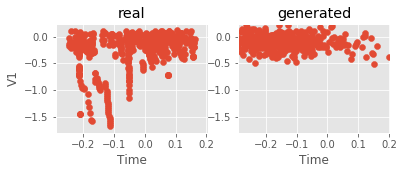

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 1.1254, 0.5397, 0.7182, 0.0000
D Real - D Gen: 0.1786


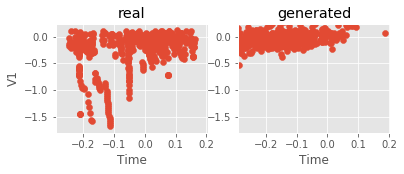

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 1.4922, 0.4124, 0.4232, 0.0000
D Real - D Gen: 0.0108


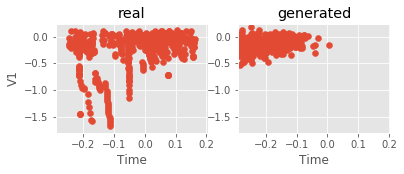

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 1.2622, 0.5192, 0.4922, 0.0000
D Real - D Gen: -0.0271


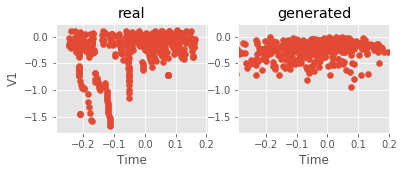

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 1.1586, 0.5632, 0.6828, 0.0000
D Real - D Gen: 0.1196


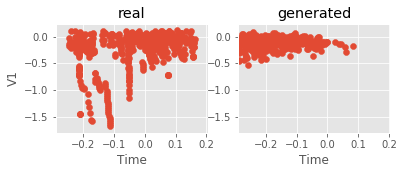

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8887, 0.7375, 0.6264, 0.0000
D Real - D Gen: -0.1111


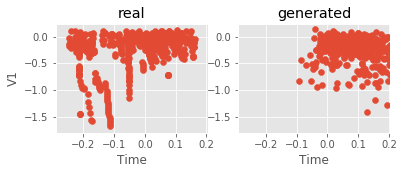

('data_dim: ', 30)
('data_cols: ', ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])
('label_dim: ', 1)
('label_cols: ', ['Class'])
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 33)           0           input_3[0][0]                    
                  

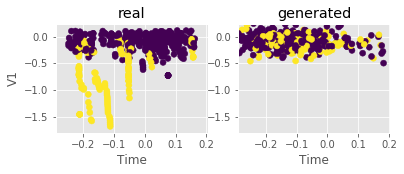

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 1.4679, 0.6087, 0.3641, 0.0000
D Real - D Gen: -0.2446


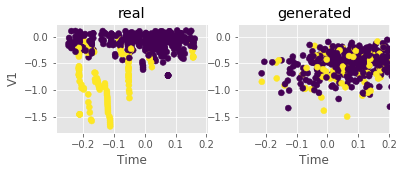

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 1.1716, 0.6196, 0.6293, 0.0000
D Real - D Gen: 0.0097


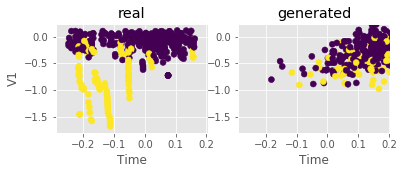

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8329, 0.7825, 0.4762, 0.0000
D Real - D Gen: -0.3063


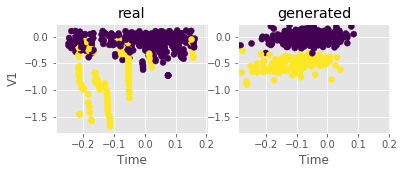

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 1.2290, 0.4930, 0.6429, 0.0000
D Real - D Gen: 0.1499


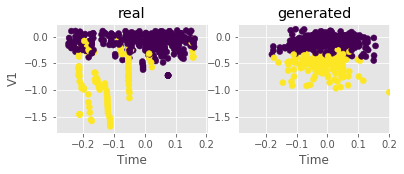

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 1.1558, 0.6295, 0.5942, 0.0000
D Real - D Gen: -0.0353


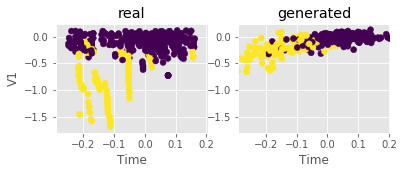

CPU times: user 1min 11s, sys: 8.83 s, total: 1min 20s
Wall time: 22.7 s


In [7]:
%%time
# Training the vanilla GAN and CGAN architectures
k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

('data_dim: ', 30)
('data_cols: ', ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_19 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 30)                15390     
Total params: 184,222
Trainable 

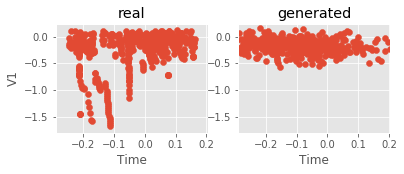

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0208, -0.0238, 0.0648, 0.0000
D Real - D Gen: 0.0887


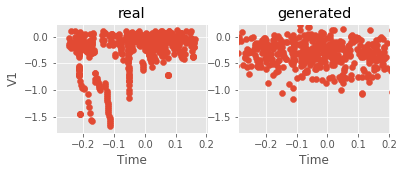

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0027, -0.0017, 0.0744, 0.0000
D Real - D Gen: 0.0761


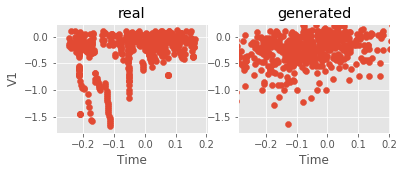

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0114, -0.0086, 0.0800, 0.0000
D Real - D Gen: 0.0886


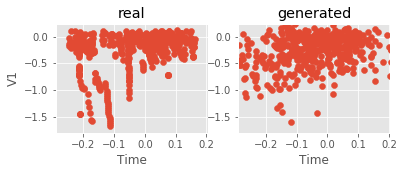

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0266, -0.0253, 0.0445, 0.0000
D Real - D Gen: 0.0698


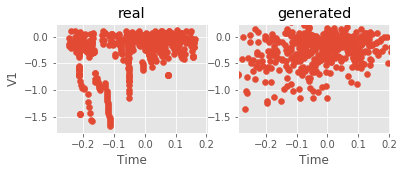

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0403, -0.0443, 0.0349, 0.0000
D Real - D Gen: 0.0792


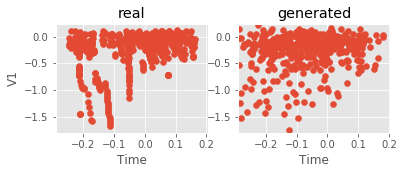

('data_dim: ', 30)
('data_cols: ', ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])
('label_dim: ', 1)
('label_cols: ', ['Class'])
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 33)           0           input_8[0][0]                    
                  

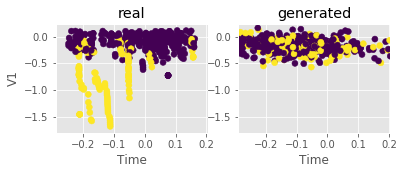

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0188, -0.0235, 0.0813, 0.0000
D Real - D Gen: 0.1048


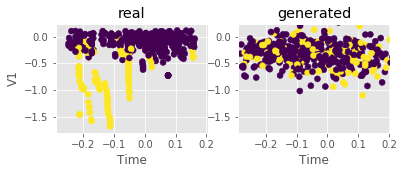

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0160, 0.0139, 0.1080, 0.0000
D Real - D Gen: 0.0941


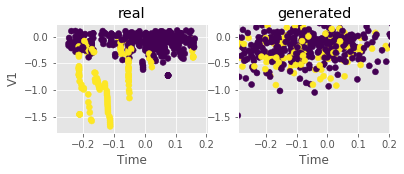

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0352, 0.0344, 0.1304, 0.0000
D Real - D Gen: 0.0960


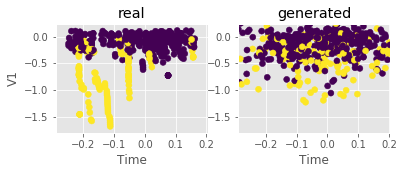

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0338, 0.0460, 0.1238, 0.0000
D Real - D Gen: 0.0778


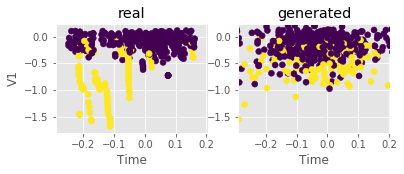

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0342, 0.0526, 0.1349, 0.0000
D Real - D Gen: 0.0823


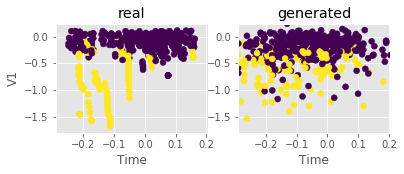

CPU times: user 5min 47s, sys: 22.4 s, total: 6min 10s
Wall time: 1min 14s


In [8]:
%%time

# Training the WGAN and WCGAN architectures
k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN